In [1]:
# !pip install concrete-python

Alice is exploring a new method to assess glycemic control using data from continuous glucose monitors. 
From The paper: $\textbf{A Simple Composite Metric for the Assessment of Glycemic Status from Continuous Glucose Monitoring Data:}$
$\textbf{Implications for Clinical Practice and the Artificial Pancreas}$
, she finds a metric called the Personal Glycemic State (PGS). PGS is a metric that is evaluating based on mean glucose levels, glycemic variability, glucose time in range, and the frequency and severity of hypoglycemia. Alice finds that PGS is a good metric for glycemic control and could be crucial for identify issues in glycemic control and optimize diabetes therapy.

Alice, as a healthcare researcher, thinks using Fully Homomorphic Encryption (FHE) in her work will benefit from several reasons. Firstly, FHE ensures the privacy of sensitive healthcare data, such as glycemic measurements, by enabling computations on encrypted data. This is crucial for maintaining patient data confidentiality. Additionally, the natural security of encyption safeguards against data breaches, an essential aspect in the healthcare. Alice can use cloud computing resources securely for data analysis. Furthermore, FHE facilitates collaboration with other researchers by enabling secure data sharing without revealing the private patient data. This is particularly beneficial in an environment where collaborative research is key to advancements. Lastly, FHE aids in compliance with stringent data protection regulations like HIPAA and GDPR, ensuring legal and ethical research practices

In [1]:
from concrete import fhe

import matplotlib.pyplot as plt
import numpy as np
from math import sin
from utils import *

The PGS composite metric contain a few part that evaluates different risk factors from Continuous Glucose Monitoring

Glycemic Variability Percentage (GVP) addresses the fluctuations of the glucose level over a given period. It is crucial, especially for persons with diabetes to maintain a stable glucose level over time. 
The paper explains to Alice that in order to calculate GVP
$$
GVP = 100 \cdot (L/L_0 - 1)
$$
she needs to know $L$ and $L_0$

$L$ is the sum of all line elements over the whole period and is calculated
$$
L = \sum_{i=1}^n\sqrt{dx^2_i+dy^2_i}
$$
where $dx$ and $dy$ is the change in time and in glucose level respectively, between each data point
$$
dy_k = glucose_k - glucose_{k-1}
$$
To calculate the PGS metric, each component has a function evaluation from 0 to 10 that describes the severity of each component.
The function for GVP is calculated with $F(GVP)$
$$
F(GVP) = 1 + \frac{9}{1+e^{-0.049\cdot(GVP-65.47)}}
$$

The second component is Mean Glucose (MG). It is simply calculated by taking the average over the glucose data
$$
MG = \frac{1}{N}\sum_{i=1}^N glucose_i
$$
and the component function for MG is 
$$
F(MG) = 1 + 9 \cdot \frac{1}{1+e^{0.1139\cdot(MG-72.08)}} + \frac{1}{1+e^{-0.09195(MG-157.57)}}
$$

Next is Percentage Time In Range (PTIR) and it measures the amount of time in percentage that the glucose level is within a healthy range.
$$
PTIR = \frac{100}{N}\sum_{i=1}^N
\begin{cases}
1, & \text{if } 70 \leq glucose_i \leq 180 \\
0, & \text{otherwise}
\end{cases}
$$
and the component function here is
$$
F(PTIR) = 1 + \frac{9}{1 + e^{0.0833(PTIR-55.04)}}
$$
Lastly, H is a two part metric that counts the amount of hypoglycemic episodes. The two part represents two different glucose level thresholds, 54 and 70 mg/dL. Both parts have different component functions aswell
$$
F_{54}(H) = 0.5 + 4.5\cdot (1-e^{-0.81093\cdot N_{54}})
$$
and
$$
F_{70}(H) = \begin{dcases}
    0.5714\cdot N_{70} & \text{if } N_{70} \leq 7.65 \\
    5 & \text{otherwise}
    \end{dcases}
$$
where the sum of these two becomes the last component function
$$
F(H) = F_{54}(H) + F_{70}(H)
$$

for the whole PGS metric
$$
PGS = F(GVP) + F(MG) + F(PTIR) + F(H)
$$

In [2]:
@fhe.compiler({"x": "encrypted"})
def PGS(x):

    # --- Calculate Glycemic Variability Percentage (GVP) --- #

    # Find dy
    dy = np.subtract(x[1:], x[:-1])

    # Assuming data points have 5 min frequency
    dx = 5

    # Length of sequence
    n = len(x)

    # Calulate L
    L = 0
    for dy_i in dy:
        L += np.sqrt(dx**2 + dy_i**2).astype(np.int64)

    # Calculate GVP
    gvp = 100*(L/(n*dx-1)).astype(np.int64)

    # Calculate the GVP component function of the PGS composite
    F_gvp = (1+9/(1+np.exp(-0.049*(gvp-65.47)))).astype(np.int64)


    
    # --- Calculate Mean Glucose (MG) --- #

    # Get average glucose level
    mg = (np.sum(x) / n ).astype(np.int64)

    # Calculate the Mean Glucose component function of the PGS composite
    F_mg = 1+(9*( 1/(1+np.exp(0.1139*(mg-72.08))) + 1/(1+np.exp(-0.09195*(mg-157.57))) )).astype(np.int64)


    
    # --- Calculate Percetage Time In Range (PTIR) --- #

    # Calculate PTIR
    in_range = 0
    for xi in x:
        in_range += np.clip(180-xi, 0, 1) - np.clip(70-xi, 0, 1)

    # Total percentage of glucose within the preferred range of 70 < x < 180
    ptir = ((in_range*100)/n).astype(np.int64)

    # Calculate the PTIR component function of the PGS composite
    F_ptir = 1+(9/(1+np.exp(0.0833*(ptir-55.04)))).astype(np.int64)


    
    # --- Calculate Hypoglycemic episodes (H) --- #

    # Calculate H54 and H70
    h54 = 0
    h70 = 0
    for xi in x:
        h54 += np.clip(54-xi, 0, 1)
        h70 += np.clip(70-xi, 0, 1)

    # Calculate the Hypoglycemic component function of the PGS composite
    F_h = ((1 + 9*(1-np.exp(-0.81093*h54/4)).astype(np.int64)) / 2).astype(np.int64)
    F_h += np.clip(7.65-h70/4, 5, 0.5714*h70/4 + 0.625).astype(np.int64)

    return F_gvp + F_mg + F_ptir + F_h

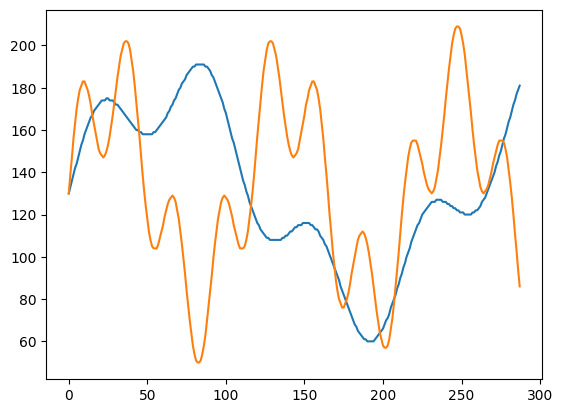

In [3]:
# Set lenght for data to analyse
length = 288

# Create data 
data_1 = [int( 130 + 50*sin(2*3.1415*i/250) + 20*sin(2*3.1415*i/70) ) for i in range(length)]
data_2 = [int( 130 + 50*sin(2*3.1415*i/110) + 30*sin(2*3.1415*i/30) ) for i in range(length)]

# Set data for copilation
inputset = [data_2[:288]]

plt.plot(data_1[:288])
plt.plot(data_2[:288])
plt.show()

In [5]:
from concrete.fhe import Configuration

# Set configuration for compiling
configuration = Configuration(loop_parallelize = True, dataflow_parallelize = False, auto_parallelize = False,)

# Compile the PGS metric for FHE
fhe_PGS = PGS.compile(inputset, p_error=0.1, fhe_simulation=True)

In [6]:
# Actual result for first data
actual = PGS(data_1)
print(actual)

# Simulated results for FHE execution
simulation = fhe_PGS.simulate(data_1)
print(simulation)

# Actual result for second data
actual = PGS(data_2)
print(actual)

# Simulated results for FHE execution
simulation = fhe_PGS.simulate(data_2)
print(simulation)

6 15
6
6
15
15
